# ***Machine Learning Base Model***

## 📚 ***Import libraries***

In [ ]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

## 💾 ***Load data***

In [9]:
DATA_DIR = Path.cwd().resolve().parents[1] / "data"
covid_df = pd.read_parquet(DATA_DIR / "02_intermediate/covid_type_fixed.parquet", engine="pyarrow")

In [10]:
columnas_df = [
    "CASE_COUNT",
    "PROBABLE_CASE_COUNT",
    "HOSPITALIZED_COUNT",
    "DEATH_COUNT",
    "CASE_COUNT_7DAY_AVG",
    "ALL_CASE_COUNT_7DAY_AVG",
    "HOSP_COUNT_7DAY_AVG",
    "DEATH_COUNT_7DAY_AVG",
]
covid_df = covid_df[columnas_df].copy()

In [11]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   CASE_COUNT               1915 non-null   int64
 1   PROBABLE_CASE_COUNT      1915 non-null   int64
 2   HOSPITALIZED_COUNT       1915 non-null   int64
 3   DEATH_COUNT              1915 non-null   int64
 4   CASE_COUNT_7DAY_AVG      1915 non-null   int64
 5   ALL_CASE_COUNT_7DAY_AVG  1915 non-null   int64
 6   HOSP_COUNT_7DAY_AVG      1915 non-null   int64
 7   DEATH_COUNT_7DAY_AVG     1915 non-null   int64
dtypes: int64(8)
memory usage: 119.8 KB


In [12]:
numeric_features = [
    "CASE_COUNT",
    "PROBABLE_CASE_COUNT",
    "HOSPITALIZED_COUNT",
    "CASE_COUNT_7DAY_AVG",
    "ALL_CASE_COUNT_7DAY_AVG",
    "HOSP_COUNT_7DAY_AVG",
    "DEATH_COUNT_7DAY_AVG",
]

In [13]:
# Function to restore feature names after ColumnTransformer processing
def restore_feature_names(X):
    return pd.DataFrame(X, columns=numeric_features)

In [14]:
numeric_pipe = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, numeric_features),
    ],
    remainder="passthrough",
)

In [15]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['CASE_COUNT', 'PROBABLE_CASE_COUNT',
                                  'HOSPITALIZED_COUNT', 'CASE_COUNT_7DAY_AVG',
                                  'ALL_CASE_COUNT_7DAY_AVG',
                                  'HOSP_COUNT_7DAY_AVG',
                                  'DEATH_COUNT_7DAY_AVG'])])

In [16]:
data_example = covid_df.drop(columns="DEATH_COUNT").sample(10, random_state=42)
data_example

,CASE_COUNT,PROBABLE_CASE_COUNT,HOSPITALIZED_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG
1232,147,98,16,262,380,21,1
111,361,24,45,324,339,49,19
316,3197,1007,309,5157,6346,356,65
781,2169,404,45,1901,2283,51,4
416,1606,487,155,1700,2255,182,38
331,5808,1417,403,4558,5771,381,79
70,657,11,123,1174,1199,192,169
721,425,72,47,753,846,64,33
618,1135,306,44,784,1038,42,8
1037,1141,451,219,2479,3262,225,30


In [17]:
preprocessor.fit_transform(data_example)

array([[-0.92559218, -0.75527699, -0.99832693, -1.01566128, -0.97491289,
        -1.07126159, -0.90891737],
       [-0.79507246, -0.92479624, -0.76597155, -0.97743216, -0.99497988,
        -0.84956666, -0.53367626],
       [ 0.93461878,  1.32706085,  1.34926368,  2.00258906,  1.94507823,
         1.58115994,  0.42527327],
       [ 0.3076362 , -0.05429198, -0.76597155, -0.00505611, -0.0435111 ,
        -0.83373131, -0.84637719],
       [-0.03574045,  0.13584448,  0.11537647, -0.12899244, -0.05721538,
         0.20348428, -0.13758841],
       [ 2.52708134,  2.26628913,  2.10241562,  1.63324648,  1.663651  ,
         1.77910185,  0.71712747],
       [-0.61454051, -0.95457665, -0.14101568, -0.45332332, -0.57406262,
         0.28266104,  2.59333306],
       [-0.75603852, -0.81483781, -0.74994704, -0.71291135, -0.74683447,
        -0.73080152, -0.24182205],
       [-0.32300581, -0.27879045, -0.7739838 , -0.69379679, -0.65286225,
        -0.90499039, -0.76299027],
       [-0.31934638,  0.0533

***Train / Test split***

In [ ]:
X_features = covid_df.drop("DEATH_COUNT", axis="columns")
Y_target = covid_df["DEATH_COUNT"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, random_state=42
)

In [19]:
x_train.shape, y_train.shape

((1532, 7), (1532,))

In [20]:
x_test.shape, y_test.shape

((383, 7), (383,))

In [23]:
# Modelo base:
model = LogisticRegression(max_iter=1000)

In [24]:
# Métricas de evaluación
scoring_metrics = ["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]
kfold = KFold(n_splits=10)

In [25]:
# Pipeline final
model_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("feature_names_restorer", FunctionTransformer(restore_feature_names, validate=False)),
        ("model", model),
    ]
)

In [26]:
# Resultados de cross-validation y entrenamiento
cv_results = {}
train_results = {}

# Evaluación de cada métrica
for metric in scoring_metrics:
    cv_results[metric] = cross_val_score(model_pipe, x_train, y_train, cv=kfold, scoring=metric)
    model_pipe.fit(x_train, y_train)
    y_train_pred = model_pipe.predict(x_train)

    # Métricas sobre entrenamiento
    if metric == "neg_mean_absolute_error":
        train_results[metric] = -mean_absolute_error(y_train, y_train_pred)
    elif metric == "neg_mean_squared_error":
        train_results[metric] = -mean_squared_error(y_train, y_train_pred)
    elif metric == "r2":
        train_results[metric] = r2_score(y_train, y_train_pred)

In [27]:
# Mostrar resumen de métricas
cv_results_df = pd.DataFrame(cv_results)
for metric in scoring_metrics:
    print(
        f"{metric} - CV mean: {cv_results_df[metric].mean():.4f}, "
        f"CV std: {cv_results_df[metric].std():.4f}"
    )
    print(f"{metric} - Train score: {train_results[metric]:.4f}")

neg_mean_absolute_error - CV mean: -8.5527, CV std: 1.6533
neg_mean_absolute_error - Train score: -7.4641
neg_mean_squared_error - CV mean: -350.1004, CV std: 181.6539
neg_mean_squared_error - Train score: -306.7226
r2 - CV mean: 0.9077, CV std: 0.1047
r2 - Train score: 0.9489


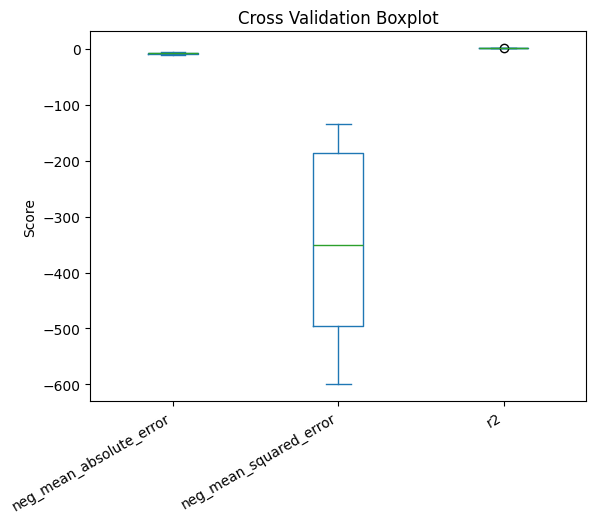

In [28]:
# Boxplot de cross-validation
ax_ = cv_results_df.plot.box(title="Cross Validation Boxplot", ylabel="Score")
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30, ha="right")
plt.show()

In [30]:
# Tabla resumen
metrics_df = pd.DataFrame(
    {
        "Metric": scoring_metrics,
        "Train Score": [train_results[metric] for metric in scoring_metrics],
        "CV Mean": [cv_results_df[metric].mean() for metric in scoring_metrics],
        "CV Std": [cv_results_df[metric].std() for metric in scoring_metrics],
    }
)
metrics_df

,Metric,Train Score,CV Mean,CV Std
0,neg_mean_absolute_error,-7.464099,-8.552657,1.653344
1,neg_mean_squared_error,-306.722585,-350.100361,181.653904
2,r2,0.948937,0.907735,0.104747


<Figure size 600x400 with 0 Axes>

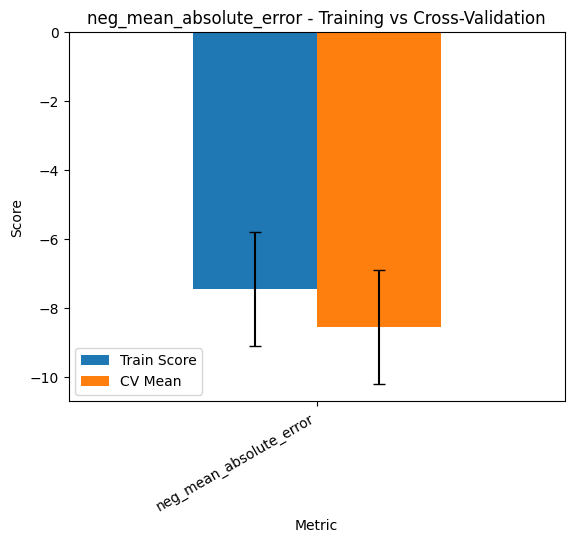

<Figure size 600x400 with 0 Axes>

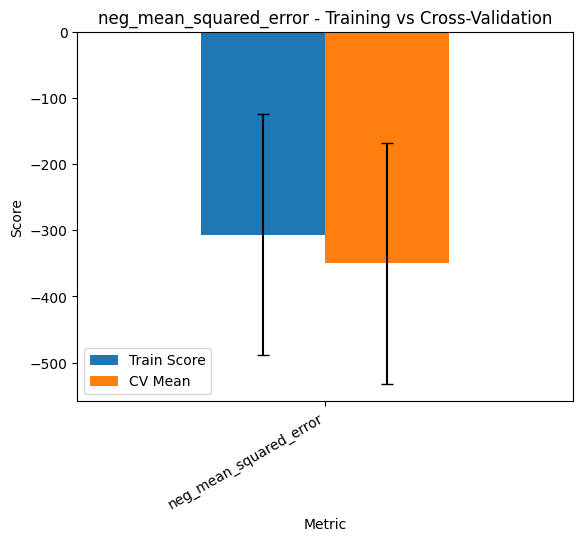

<Figure size 600x400 with 0 Axes>

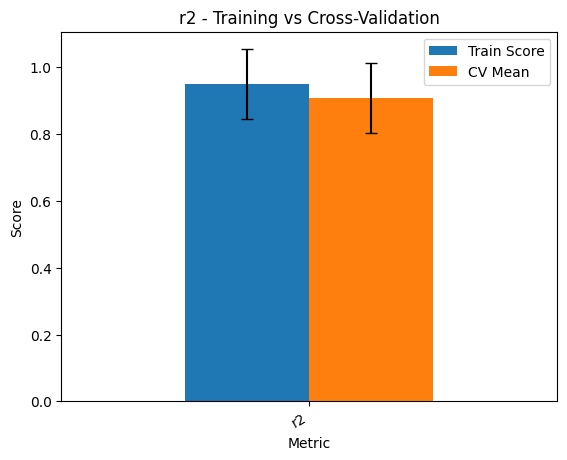

In [31]:
# Gráficas comparativas por métrica
for metric in scoring_metrics:
    plt.figure(figsize=(6, 4))
    metric_df = metrics_df[metrics_df["Metric"] == metric]
    ax = metric_df.plot(
        kind="bar",
        x="Metric",
        y=["Train Score", "CV Mean"],
        yerr="CV Std",
        title=f"{metric} - Training vs Cross-Validation",
        ylabel="Score",
        capsize=4,
        legend=True,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
    plt.show()

In [32]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    model_pipe,
    x_train,
    y_train,
    cv=kfold,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)

In [33]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

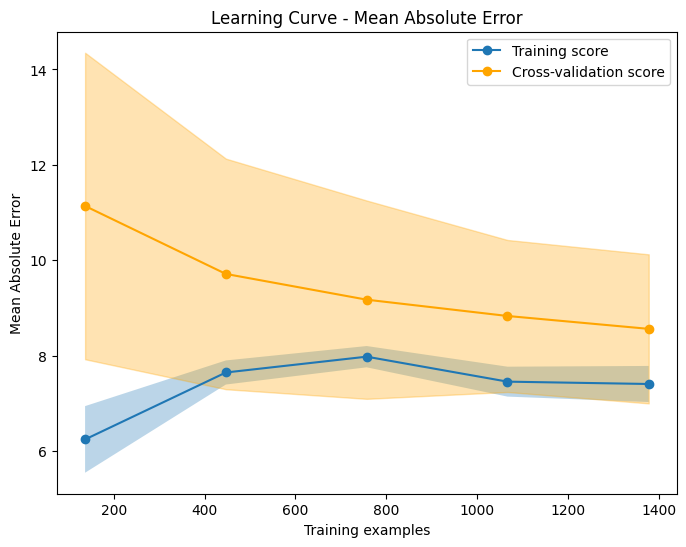

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, -train_mean, "o-", label="Training score")
plt.plot(train_sizes, -test_mean, "o-", label="Cross-validation score", color="orange")
plt.fill_between(train_sizes, -train_mean - train_std, -train_mean + train_std, alpha=0.3)
plt.fill_between(
    train_sizes, -test_mean - test_std, -test_mean + test_std, alpha=0.3, color="orange"
)
plt.title("Learning Curve - Mean Absolute Error")
plt.xlabel("Training examples")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

# 😷📊 ***Análisis de Resultados del Modelo Base - COVID-19 NYC***

### ***Mean Absolute Error (MAE)***
- ***CV Mean:*** -8.5527
- ***CV Std:*** 1.6533
- ***Train Score:*** -7.4641
***Interpretación:*** El error absoluto medio en cross-validation es relativamente bajo, lo que indica que el modelo logra capturar una buena aproximación al número de muertes diarias. La desviación estándar moderada (~1.6) implica una variabilidad aceptable entre los distintos folds de validación.

### ***Mean Squared Error (MSE)***
- ***CV Mean:*** -350.1004
- ***CV Std:*** 181.6539
- ***Train Score:*** -306.7226
***Interpretación:*** El MSE tiene valores negativos grandes, pero esto se espera al utilizar neg_mean_squared_error. Su magnitud se debe a que penaliza más fuertemente los errores grandes. Aunque los errores extremos en algunos casos generan una desviación estándar relativamente alta (~181.6).

### ***R² Score***
- ***CV Mean:*** 0.9077
- ***CV Std:*** 0.1047
- ***Train Score:*** 0.9489
***Interpretación:*** El valor promedio de R² es muy alto (> 0.90), lo cual indica que el modelo explica más del 90% de la varianza del número de muertes. El rendimiento en entrenamiento es aún mejor, lo cual era esperable. La desviación estándar moderada muestra que el modelo se comporta consistentemente en diferentes subconjuntos de datos.

# ***Recomendaciones***
- Continuar con este modelo como baseline
La regresión logística ha logrado resultados sólidos como punto de partida. No se observa sobreajuste severo ni errores sistemáticamente altos.

- Probar modelos más complejos
Propuesta: entrenar modelos como RandomForestRegressor o XGBoost. Estos modelos podrían mejorar la captura de no linealidades y relaciones más complejas entre variables.

# ***Propuestas e Ideas***
#### ***Incrementar robustez del modelo***
Incluir validación cruzada estratificada si se categorizan las muertes.

# 📌 ***Conclusiones***
El modelo base con regresión logística ofrece una muy buena línea de referencia para predecir el número de muertes por COVID-19 en NYC. Las métricas obtenidas muestran una capacidad predictiva significativa y una generalización adecuada, con posibilidad de mejora al emplear modelos más sofisticados.